In [1]:
import tensorflow as tf

In [2]:
# Check if TensorFlow is using the GPU
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
with tf.device('/GPU:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0])
    b = tf.constant([5.0, 4.0, 3.0, 2.0, 1.0])
    c = tf.multiply(a, b)

# Print the result
print(c)

tf.Tensor([5. 8. 9. 8. 5.], shape=(5,), dtype=float32)


In [4]:
import sys
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time
import itertools
import random

from sklearn.utils import shuffle

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from tensorflow.keras.models import Model

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense, Layer
from tensorflow.keras.initializers import glorot_uniform

from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [21]:
from tensorflow.keras.models import load_model

In [5]:
path = "D:/DOWNLOADS/cheques/data/signatures"

### Data Preprocessing

In [6]:
from natsort import natsorted, ns
orig_groups, forg_groups = [], []
images = os.listdir(path+"/full_forg")
images=natsorted(images, alg=ns.IGNORECASE)
images = [path+"/full_forg"+'/'+x for x in images]

for i in range(0,len(images)-1,24):
    forg_groups.append(images[i:i+24]) 
images = os.listdir(path+"/full_org")
images=natsorted(images, alg=ns.IGNORECASE)
images = [path+"/full_org"+'/'+x for x in images]

for i in range(0,len(images)-1,24):
    orig_groups.append(images[i:i+24])

In [7]:
len(orig_groups), len(forg_groups)

(55, 55)

### Train-Validation-Test Split

In [8]:
orig_train, orig_val, orig_test = orig_groups[:42], orig_groups[42:49], orig_groups[49:55]
forg_train, forg_val, forg_test = forg_groups[:42], forg_groups[42:49], forg_groups[49:55]

In [9]:
img_h, img_w = 155, 220

In [10]:
def generate_batch(orig_groups, forg_groups, batch_size = 32):
    '''Function to generate a batch of data with batch_size number of data points
    Half of the data points will be Genuine-Genuine pairs and half will be Genuine-Forged pairs'''
    while True:
        orig_pairs = []
        forg_pairs = []
        genuine_labels = []
        forged_labels = []
        all_pairs = []
        all_labels = []
        
        
        for orig, forg in zip(orig_groups, forg_groups):
            orig_pairs.extend(list(itertools.combinations(orig, 2)))
            for i in range(len(forg)):
                forg_pairs.extend(list(itertools.product(orig[i:i+1], random.sample(forg, 12))))
        
        # Label for Genuine-Genuine pairs is 1
        # Label for Genuine-Forged pairs is 0
        genuine_labels = [1]*len(orig_pairs)
        forged_labels = [0]*len(forg_pairs)
        
        # Concatenate all the pairs together along with their labels and shuffle them
        all_pairs = orig_pairs + forg_pairs
        all_labels = genuine_labels + forged_labels
        del orig_pairs, forg_pairs, genuine_labels, forged_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)
        
             
        k = 0
        pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
        Y=np.zeros((batch_size,))
        for ix, pair in enumerate(all_pairs):
            img1 = cv2.imread(pair[0], 0)
            img2 = cv2.imread(pair[1], 0)
            img1 = cv2.resize(img1, (img_w, img_h))
            img2 = cv2.resize(img2, (img_w, img_h))
            
            img1 = cv2.threshold(img1, 127, 255, cv2.THRESH_BINARY)[1]
            img2 = cv2.threshold(img2, 127, 255, cv2.THRESH_BINARY)[1]
            
            img1 = np.array(img1, dtype = np.float64)
            img2 = np.array(img2, dtype = np.float64)

            '''Converting white patches to 255 pixel and black patches to 0 pixel for increasing accuracy'''
            for i in range(img1.shape[0]):
                for j in range(img1.shape[1]):
                    pixel = img1.item(i, j)
                    if pixel > 200:
                        img1[i][j]=255
                    else:
                        img1[i][j]=0
            for i in range(img2.shape[0]):
                for j in range(img2.shape[1]):
                    pixel = img2.item(i, j)
                    if pixel > 200:
                        img2[i][j]=255
                    else:
                        img2[i][j]=0
            img1 /= 255
            img2 /= 255
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            Y[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                yield pairs, Y
                k = 0
                pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
                targets=np.zeros((batch_size,))

In [11]:
def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [12]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [13]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [14]:
def create_base_network_signet(input_shape):
    '''Base Siamese Network'''

    inputs = Input(shape=input_shape)
    
    x = Conv2D(96, kernel_size=(11, 11), activation='relu', kernel_initializer='he_normal', strides=4, padding='valid')(inputs)
    x = BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9)(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    x = ZeroPadding2D(padding=(2, 2))(x)
    
    x = Conv2D(256, kernel_size=(5, 5), activation='relu', kernel_initializer='he_normal', strides=1)(x)
    x = BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9)(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    x = Dropout(0.3)(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    
    x = Conv2D(384, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', strides=1)(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    
    x = Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', strides=1)(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    x = Dropout(0.3)(x)
    
    x = Flatten()(x)
    x = Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(128, activation='relu', kernel_initializer='he_normal')(x)
    
    model = Model(inputs=inputs, outputs=x)
    return model


In [15]:
#Image dimensions
input_shape=(img_h, img_w, 1)

In [16]:
# network definition
base_network = create_base_network_signet(input_shape)

input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Compute the Euclidean distance between the two vectors in the latent space
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

In [17]:
batch_sz = 128
num_train_samples = 276*42 + 300*42
num_val_samples =  276*7 + 300*7 
num_test_samples =276*6 + 300*6 
num_train_samples, num_val_samples, num_test_samples

(24192, 4032, 3456)

In [18]:
# compile model using RMSProp Optimizer and Contrastive loss function defined above
rms = RMSprop(learning_rate=1e-4, rho=0.9, epsilon=1e-08)
model.compile(loss=contrastive_loss, optimizer=rms)

In [19]:
callbacks = [
    EarlyStopping(patience= 5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('D:/DOWNLOADS/cheques/data/signet-{epoch:03d}.h5', verbose=1, save_weights_only=True)
]

In [20]:
results = model.fit(generate_batch(orig_train, forg_train, batch_sz),
                    steps_per_epoch = num_train_samples//batch_sz,
                    epochs = 7,
                    validation_data = generate_batch(orig_val, forg_val, batch_sz),
                    validation_steps = num_val_samples//batch_sz,
                    callbacks = callbacks)

Epoch 1/7
189/189 [==============================] - 859s 5s/step - loss: 6.3363 - val_loss: 0.4969

Epoch 00001: saving model to D:/DOWNLOADS/cheques/data\signet-001.h5
Epoch 2/7
189/189 [==============================] - 891s 5s/step - loss: 0.2806 - val_loss: 0.5004

Epoch 00002: saving model to D:/DOWNLOADS/cheques/data\signet-002.h5
Epoch 3/7
189/189 [==============================] - 888s 5s/step - loss: 0.2735 - val_loss: 0.5085

Epoch 00003: saving model to D:/DOWNLOADS/cheques/data\signet-003.h5
Epoch 4/7
189/189 [==============================] - 896s 5s/step - loss: 0.2708 - val_loss: 0.4891

Epoch 00004: saving model to D:/DOWNLOADS/cheques/data\signet-004.h5
Epoch 5/7
189/189 [==============================] - 863s 5s/step - loss: 0.2648 - val_loss: 0.4663

Epoch 00005: saving model to D:/DOWNLOADS/cheques/data\signet-005.h5
Epoch 6/7
189/189 [==============================] - 1790s 10s/step - loss: 0.2544 - val_loss: 0.3841

Epoch 00006: saving model to D:/DOWNLOADS/chequ

In [23]:
file_path = 'D:/DOWNLOADS/cheques/data/set2/signet-007.h5'
if os.path.exists(file_path):
    print("File exists")
else:
    print("File does not exist")

File exists


In [24]:
test_gen = generate_batch(orig_test, forg_test, 1)
pred, tr_y = [], []
for i in range(num_test_samples):
    (img1, img2), label = next(test_gen)
    tr_y.append(label)
    pred.append(model.predict([img1, img2])[0][0])

In [26]:
def compute_accuracy_roc(predictions, labels, plot_far_frr =False):
    '''
    Compute ROC accuracy with a range of thresholds on distances.
    Plot FAR-FRR curves and P-R curves to monitor performance of model on input set.
    '''
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1) #similar
    ndiff = np.sum(labels == 0) #different
    step = 0.01
    max_acc = 0
    best_thresh = -1
    frr_plot = []
    far_plot = []
    pr_plot = []
    re_plot = []
    ds = []
    for d in np.arange(dmin, dmax+step, step):
        idx1 = predictions.ravel() <= d #guessed genuine
        idx2 = predictions.ravel() > d #guessed forged
        tp = float(np.sum(labels[idx1] == 1))
        tn = float(np.sum(labels[idx2] == 0))
        fp = float(np.sum(labels[idx1] == 0))
        fn = float(np.sum(labels[idx2] == 1))
#         print(tp, tn, fp, fn)
        tpr = float(np.sum(labels[idx1] == 1)) / nsame       
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        
        
        acc = 0.5 * (tpr + tnr)
        pr = tp / (tp + fp)
        re = tp / (tp + fn)
#       print ('ROC', acc, tpr, tnr)
       
        if (acc > max_acc):
            max_acc, best_thresh = acc, d
        
        #if (fp+tn) != 0.0 and (fn+tp) != 0.0:
        far = fp / (fp + tn)
        frr = fn / (fn + tp)
        frr_plot.append(frr)
        pr_plot.append(pr)
        re_plot.append(re)
        far_plot.append(far)
        ds.append(d)
            
    
    if plot_far_frr:
        fig = plt.figure(figsize = (10,10))
        ax = fig.add_subplot(121)
        ax.plot(ds, far_plot, color = 'red')
        ax.plot(ds, frr_plot, color = 'blue')
        ax.set_title('Error rate')
        ax.legend(['FAR', 'FRR'])
        ax.set(xlabel = 'Thresholds', ylabel = 'Error rate')
        
        ax1 = fig.add_subplot(122)
        ax1.plot(ds, pr_plot, color = 'green')
        ax1.plot(ds, re_plot, color = 'magenta')
        ax1.set_title('P-R curve')
        ax1.legend(['Precision', 'Recall'])
        ax.set(xlabel = 'Thresholds', ylabel = 'Error rate')
        
        plt.show()
    return max_acc, best_thresh
        

In [27]:
tr_acc, threshold = compute_accuracy_roc(np.array(pred), np.array(tr_y))
tr_acc, threshold

(0.5390070921985816, 0.04)

In [28]:
def predict_score():
    '''Predict distance score and classify test images as Genuine or Forged'''
    test_point, test_label = next(test_gen)
    img1, img2 = test_point[0], test_point[1]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Genuine')
    if test_label == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold:
        print("Its a Forged Signature")
    else:
        print("Its a Genuine Signature")

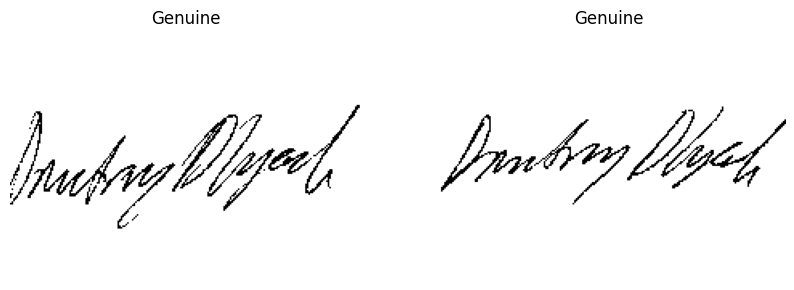

Difference Score =  0.0
Its a Genuine Signature


In [35]:
predict_score()

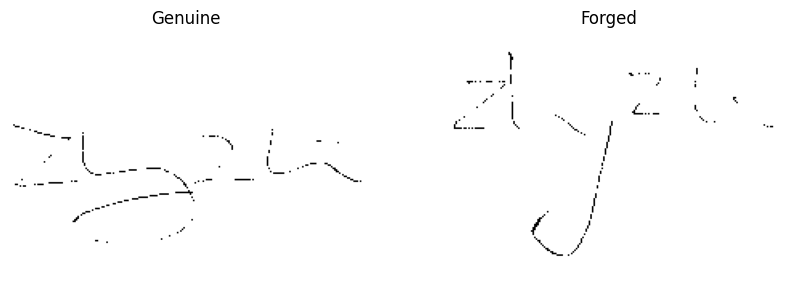

Difference Score =  0.11089151
Its a Forged Signature


In [43]:
predict_score()

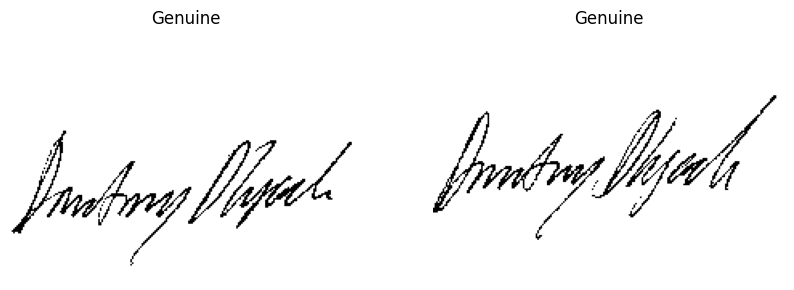

Difference Score =  0.0
Its a Genuine Signature


In [50]:
predict_score()